<a href="https://colab.research.google.com/github/kghhhhui/kgh/blob/main/03_Spectral_Subtraction_baby_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral Subtraction
예시대로 해보자

In [109]:
import numpy as np
import scipy
import signal

In [110]:
""" Begin with utility functions to convert the given audio into a list of audio-frames and back"""
#01. 주어진 오디오를 오디오 프레임 목록으로 변환하고 되돌리는 유틸리티 기능 부터 시작

# Using scipy's stft/istft function; see scipy's stft source code for details
#1) audio_to_frames 함수 : STFT. STFT는 시간 신호 → 주파수영역으로 변환
def audio_to_frames(y: np.array, m, hop_size, fs)-> np.array:
    """Convert y[n] into a matrix of frames Y_m(w) where each row is a time slice"""
    _, _, Zxx= scipy.signal.stft(y, fs=fs, nperseg=m, noverlap=hop_size, nfft=m*8)
    return Zxx.T #Zxx를 전치시켜 반환

#2) frames_to_audio 함수: ISTFT. ISTFT는 STFT의 역변환으로, 주파수 영역의 신호를 다시 시간 영역으로 변환하여 원래 오디오 신호로 복원
def frames_to_audio(Y: np.array, m, hop_size, fs)-> np.array:
    """Convert Y_m(w) matrix of frames into a 1D signal y[n] using Overlap-Add"""
    _, xrec= scipy.signal.istft(Y.T, fs=fs, nperseg=m, noverlap=hop_size, nfft=m*8)
    return xrec

In [111]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Clean audio


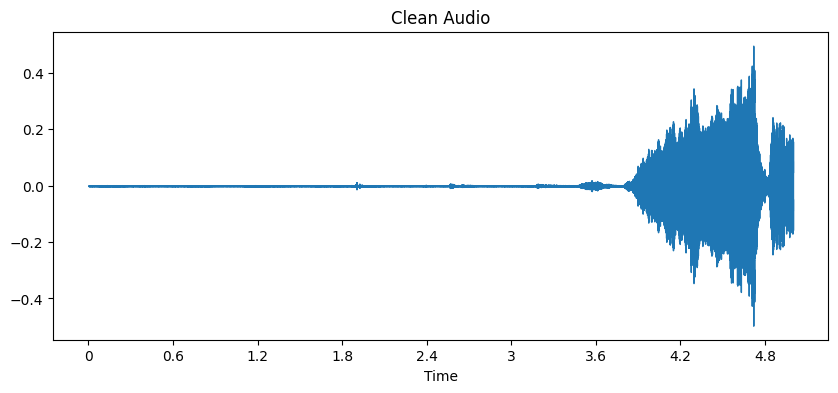

In [112]:
# Clean audio #깨끗한 음성 신호 오디오 형식으로 재생
print("Clean audio")
plt.figure(figsize=(10, 4))
librosa.display.waveshow(x, sr=fs)
plt.title("Clean Audio")
plt.show()
IPython.display.display(Audio(x, rate=fs))

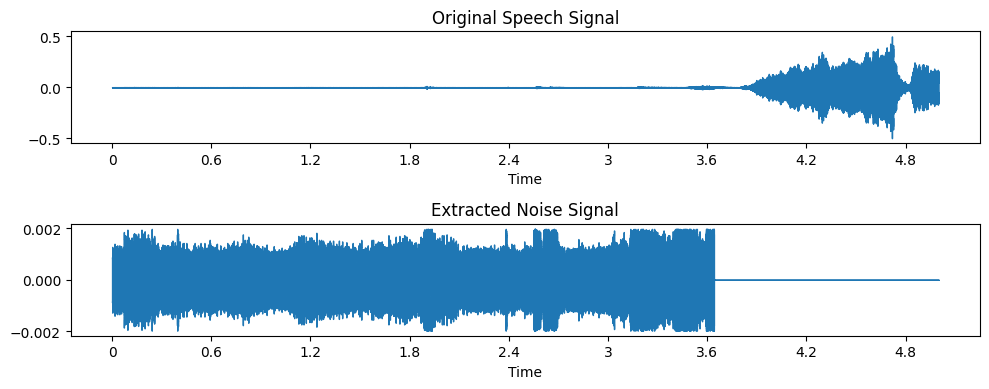

In [113]:
#노이즈 음성 부분을 찾기
#why? -> 원본에 삐 소리가 있어서 제거하고 싶음
#노이즈만 추출한 결과, 삐 소리를 대부분 추출(그러나 아기 울음소리도 조금 섞임)
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

def extract_noise(signal, threshold_amplitude):
    # 원본 음성 신호의 진폭 값을 계산
    amplitude = np.abs(signal)

    # 노이즈 음성 부분을 탐지하여 추출
    noise_mask = amplitude < threshold_amplitude
    noise_signal = signal[noise_mask]

    return noise_signal

# 원본 음성 신호 로드
speech_file = "/content/drive/MyDrive/baby/baby-data-main/sample/sad/03-02-04-01-87-150-03-01-00-14-04.wav"
x, fs = librosa.load(speech_file, sr=16000)

# 노이즈 음성 추출을 위한 진폭 기준값 설정 (적절한 값으로 조정)
threshold_amplitude = 0.002

# 노이즈 음성 부분 추출
noise_signal = extract_noise(x, threshold_amplitude)

# 노이즈 음성 부분의 길이를 원본 음성의 길이에 맞춤
#(노이즈 음성 뒷부분 0으로 패딩해서 소리 안 남)
if len(noise_signal) > len(x):
    noise_signal = noise_signal[:len(x)]
else:
    padding = np.zeros(len(x) - len(noise_signal))
    noise_signal = np.concatenate((noise_signal, padding))

# 파형 그래프 그리기
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
librosa.display.waveshow(x, sr=fs)
plt.title("Original Speech Signal")
IPython.display.display(Audio(x, rate=fs))

plt.subplot(2, 1, 2)
librosa.display.waveshow(noise_signal, sr=fs)
plt.title("Extracted Noise Signal")
plt.tight_layout()
plt.show()
IPython.display.display(Audio(noise_signal, rate=fs))

In [114]:
# """ Generate the noisy speech signal from a clean speech signal by adding noise"""
# #02. 원본 음성에 노이즈 추가

# import librosa

# speech_file= "/content/drive/MyDrive/baby/baby-data-main/sample/sad/03-02-04-01-87-150-03-01-00-14-04.wav" #원본 음성 신호 로드
# noise_file= noise_signal #노이즈 로드

# x, fs= librosa.load(speech_file, sr=16000)
# # 음성신호를 x 배열로 로드, fs를 sr=16000으로 받기
# n, fs_noise= librosa.load(noise_file, sr=16000)

# # 음성 신호(x)와 노이즈 신호(n)의 길이를 맞춤
# min_len = min(len(x), len(n))
# x = x[:min_len]
# n = n[:min_len]

# noise_gain= 0.7 #노이즈 신호(n) 크기를 조절하기 위한 값
# n= noise_gain* n[:len(x)]
# #n의 길이를 음성신호(x)와 동일하게 만들기 위해 x의 길이 자름

y= x+ noise_signal #노이즈 신호 + 음성신호 = 노이즈 음성신호(y)

# Compute the SNR for signal x to noise n #y와 x의 snr 계산하기
##snr : 높을수록 노이즈 적은 더 깨끗한 음성 신호 의미함
y_snr= 10*np.log10(np.sum(x**2)/np.sum(noise_signal**2))
print("SNR: {:.2f}dB".format(y_snr)) #계산된 snr 출력

SNR: 36.62dB


In [115]:
# #노이즈 음성 신호를 제작해보자 (실패함)
# import librosa
# import numpy as np
# import matplotlib.pyplot as plt
# import librosa.display

# def cut_below_threshold(signal, threshold_amplitude, hop_size, n_fft):
#     # 기준 진폭 이하의 부분을 찾기 위해 진폭 스펙트럼을 계산
#     amplitude_spectrum = np.abs(librosa.stft(signal, hop_length=hop_size, n_fft=n_fft))

#     # threshold_amplitude를 오디오 신호로 로드하여 변환
#     #threshold_spectrum = np.full(amplitude_spectrum.shape, threshold_amplitude)
#     threshold_spectrum = np.ones_like(amplitude_spectrum) * threshold_amplitude
#     #threshold_spectrum = np.abs(threshold_amplitude)

#     # 기준 진폭 이하의 부분을 찾아서 잘라냄
#     signal_cut = np.where(amplitude_spectrum < threshold_spectrum, 0, signal)
#     return signal_cut

# # 원본 음성 신호 로드
# speech_file = "/content/drive/MyDrive/baby/baby-data-main/sample/sad/03-02-04-01-87-150-03-01-00-14-04.wav"
# x, fs = librosa.load(speech_file, sr=16000)

# # 기준 진폭 설정 (이하의 부분을 자르기 위한 기준값)
# threshold_amplitude = 0.1

# # STFT 파라미터 설정
# hop_size = 512  # 슬라이딩 창의 크기
# n_fft = 2048   # FFT의 크기

# # 기준 진폭 이하의 부분만 자르기
# x_cut = cut_below_threshold(x, threshold_amplitude, hop_size, n_fft)

# # 스펙트럼을 시간 영역의 음성 신호로 변환 (ISTFT)
# x_reconstructed = librosa.istft(x_cut, hop_length=hop_size, win_length=n_fft)

# # 결과 확인을 위해 파형 그래프 그리기
# plt.figure(figsize=(10, 4))
# librosa.display.waveshow(x, sr=fs, label="Original")
# librosa.display.waveshow(x_cut, sr=fs, label="Below Threshold")
# plt.legend()
# plt.title("Original vs Below Threshold")
# plt.show()

In [116]:
"""Convert the signal into overlapping frames and take Short-time Fourier Transform (STFT)"""
#03. 오디오 신호 y를 오디오프레임으로 변환 후, STFT 수행

win_t= 30e-3# window size in seconds # 윈도우 크기를 초 단위로 나타냄(0.03초).
#윈도우 크기는 STFT에서 사용할 각 프레임의 길이 결정
win_s= round(fs*win_t)# window size in samples
#STFT에서 사용할 프레임 길이를 샘플 단위로 나타냄
hop_size= win_s//2 #인접하는 프레임들 간의 중첩 크기를 결정하는 값 #보통 50% 중첩
Y= audio_to_frames(y, win_s, hop_size, fs)
#오디오 신호 y -> 오디오 프레임 -> STFT를 수행 = 주파수 영역의 표현 얻기

In [117]:
# """ (Step 1) Implement the adaptive noise estimation algorithm for speech enhancement""" #음성 향상을 위한 적응적 노이즈 추정 알고리즘 구현
# def noise_estimation_snr(Y: np.array)-> (np.array, np.array):
#     """Estimates the magnitude and power spectrum of the noise for each frame"""
# # STFT 결과인 Y를 입력으로 받고, 각 프레임에 대해 노이즈의 크기를 추정한 결과를 반환

# # Prepare the output variables
#     est_Mn= np.zeros(Y.shape)
#     est_Pn= np.zeros(Y.shape)
# # Y와 같은 크기의 배열(노이즈 크기와 파워 스펙트럼 저장 용도)을 각각 0으로 초기화.

#     N= 10 # Number of frames to use for estimating a-posteriori SNR
# 					#SNR 추정하는데 사용할 프레임 수 결정

# # Iterate through each frame and estimate noise
#     for m in range(Y.shape[0]):
#         if m< N: #처음 10개(N)에 대해서는 Y 그대로 사용
# # Use noisy spectra for first 10 iterations
# #10개 이후부터는 노이즈 크기 추정 알고리즘 수행
#             est_Mn[m]= abs(Y[m])
#             est_Pn[m]= est_Mn[m]** 2
#         else:
#             a= 25
# # A-posteriori SNR
#             gammak= (abs(Y[m])**2)/np.mean(abs(Y[m-N:m])**2, axis=0)
# 						#현재 프레임(m)의 크기를 N개의 인접한 프레임의 평균 크기로 나눈 값
#             alpha= 1/(1+np.exp(-a*(gammak-1.5)))
# 						#노이즈 추정에 사용할 가중치 alpha를 계산
#             est_Mn[m]= alpha* abs(est_Mn[m-1])+ (1-alpha)* abs(Y[m])
# 						#현재 프레임(m) 크기 추정. 선형 보간 사용
#             est_Pn[m]= alpha* (abs(est_Mn[m-1])**2)+ (1-alpha)* (abs(Y[m])**2)
# 						#추정한 노이즈 크기에 해당하는 파워 스펙트럼 계산. 선형보간 사용

#     return est_Mn, est_Pn #추정된 노이즈 크기와 파워스펙트럼 반환

# est_Mn, est_Pn= noise_estimation_snr(Y)
# #Y를 이용하여 노이즈 크기(est_Mn)와 파워 스펙트럼 추정 후, est_Pn에 할당

In [118]:
#위와 동일. 주석 제거.

def noise_estimation_snr(Y: np.array) -> (np.array, np.array):
    est_Mn = np.zeros(Y.shape)
    est_Pn = np.zeros(Y.shape)
    N = 10
    for m in range(Y.shape[0]):  # Add the colon ':' at the end
        if m < N:
            est_Mn[m] = abs(Y[m])
            est_Pn[m] = est_Mn[m] ** 2
        else:
            a = 25
            gammak = (abs(Y[m]) ** 2) / np.mean(abs(Y[m-N:m]) ** 2, axis=0)
            alpha = 1 / (1 + np.exp(-a * (gammak - 1.5)))
            est_Mn[m] = alpha * abs(est_Mn[m-1]) + (1 - alpha) * abs(Y[m])
            est_Pn[m] = alpha * (abs(est_Mn[m-1]) ** 2) + (1 - alpha) * (abs(Y[m]) ** 2)
    return est_Mn, est_Pn

est_Mn, est_Pn = noise_estimation_snr(Y)


In [119]:
""" (Step 2) Estimate the clean signal from (a) the noisy signal and (b) estimate of the noise magnitude"""
# STFT(Y)와 노이즈 크기(est_Mn) 사용해 노이즈 음성으로 부터 깨끗한 신호 추정

def spec_subtract_mag(Y, est_Mn)-> np.array:
    est_magX= np.maximum(abs(Y)- est_Mn, 0)
    est_phaseX= np.angle(Y)
    est_Sx= est_magX* np.exp(1j*est_phaseX)
    return est_Sx
# 'Y - 추정된 노이즈 크기' 후, est_Sx(깨끗한 스펙트로그램) 생성

def spec_subtract_pow(Y, est_Pn)-> np.array:
    est_powX= np.maximum(abs(Y)**2- est_Pn, 0)
    est_phaseX= np.angle(Y)
    est_Sx= np.sqrt(est_powX)* np.exp(1j*est_phaseX)
    return est_Sx
# 'Y - 추정된 파워 스펙트럼' 후, est_Sx(깨끗한 스펙트로그램) 생성

est_Sx_mag= spec_subtract_mag(Y, est_Mn)
est_Sx_pow= spec_subtract_pow(Y, est_Pn)
#추정된 깨끗한 스펙트로그램 ->  노이즈가 제거된 오디오 프레임
##오디오 프레임 -> 오디오 신호로 복원 위해 ISTFT 사용하면 깨끗한 음성 신호 얻기 가능

##실제 음성에서 노이즈 추출해보자 -> ?

Noisy audio


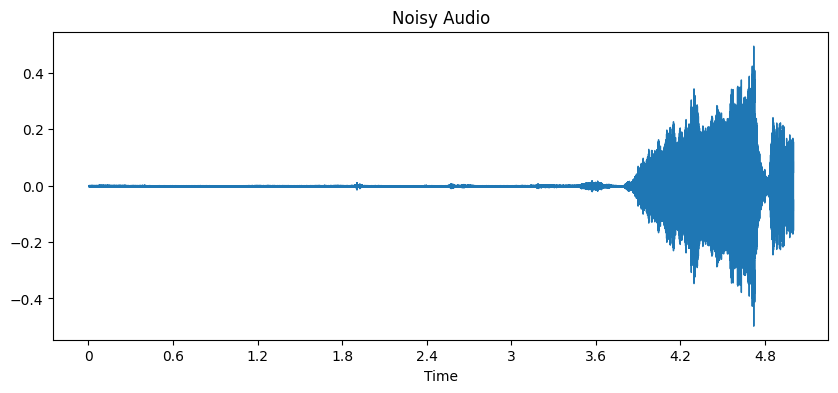

Clean audio


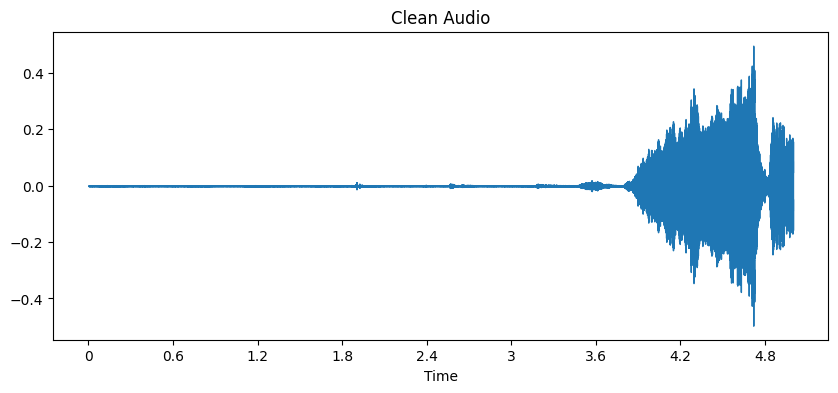

Estimate based on magnitude spectral subtraction


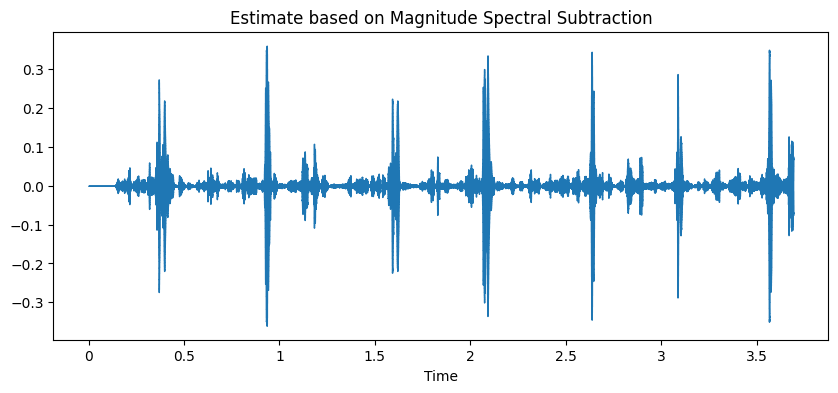

Estimate based on power spectral subtraction


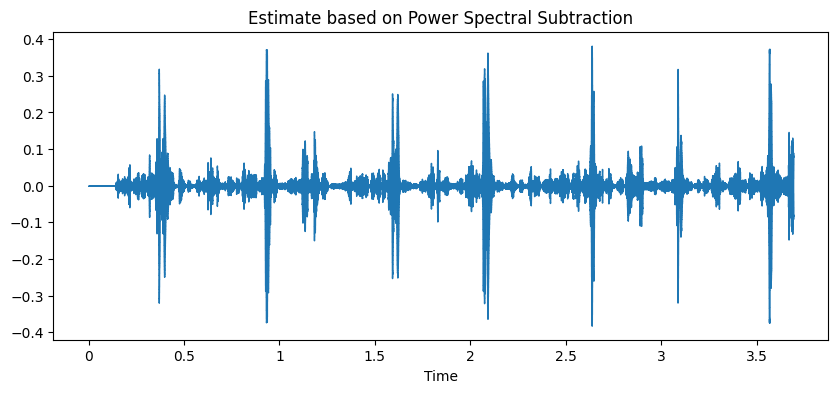

In [122]:
import librosa.display
import matplotlib.pyplot as plt

# Noisy audio #노이즈 음성 신호 오디오 형식으로 재생
print("Noisy audio")
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=fs)
plt.title("Noisy Audio")
plt.show()
IPython.display.display(Audio(y, rate=fs))

# Clean audio #깨끗한 음성 신호 오디오 형식으로 재생
print("Clean audio")
plt.figure(figsize=(10, 4))
librosa.display.waveshow(x, sr=fs)
plt.title("Clean Audio")
plt.show()
IPython.display.display(Audio(x, rate=fs))

# Estimate based on magnitude spectral subtraction
# 노이즈 제거된 깨끗한 음성 신호 추정 결과 재구성하여 오디오 형식으로 재생
# ISTFT 이용하여 시간영역으로 변환 후, 원본 음성과 같은 길이로 자르기
print("Estimate based on magnitude spectral subtraction")
plt.figure(figsize=(10, 4))
librosa.display.waveshow(x_hat_mag, sr=fs)
plt.title("Estimate based on Magnitude Spectral Subtraction")
plt.show()
IPython.display.display(Audio(x_hat_mag, rate=fs))

# Estimate based on power spectral subtraction
# 노이즈 제거된 깨끗한 음성 신호 추정 결과 재구성하여 오디오 형식으로 재생
# ISTFT 이용하여 시간영역으로 변환 후, 원본 음성과 같은 길이로 자르기
print("Estimate based on power spectral subtraction")
plt.figure(figsize=(10, 4))
librosa.display.waveshow(x_hat_pow, sr=fs)
plt.title("Estimate based on Power Spectral Subtraction")
plt.show()
IPython.display.display(Audio(x_hat_pow, rate=fs))